In [11]:
import pandas as pd
import numpy as np

from pathlib import Path


## Merge data

In [43]:
def build_panel_1s(quotes_fp: Path, prices_fp: Path, trades_fp: Path) -> pd.DataFrame:
    q = pd.read_parquet(quotes_fp).set_index('ts').add_prefix("q_")
    p = pd.read_parquet(prices_fp).set_index('ts').add_prefix("p_")
    t = pd.read_parquet(trades_fp).set_index('ts').add_prefix("t_")

    # Inner join = only timestamps where all three exist
    panel = q.join(p, how="inner").join(t, how="inner")

    quote_cols = [c for c in panel.columns if c.startswith("q_")]
    panel[quote_cols] = panel[quote_cols].ffill()

    # Drop any rows that still have missing core state
    panel = panel.dropna(subset=["q_mid", "q_spread"])

    return panel


In [46]:
BASE = Path("../data")

ticker = "IVV"
date = '2025-05-02'

quotes_fp = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

panel = build_panel_1s(quotes_fp, prices_fp, trades_fp)
print(panel.shape)
print(panel.columns)
print(panel.head())


(23400, 22)
Index(['q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size', 'q_mid',
       'q_spread', 'q_imbalance_l1', 'q_microprice', 'q_microprice_dev',
       'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close', 'p_volume',
       'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades', 't_vwap',
       't_symbol'],
      dtype='object')
                           q_bid_price  q_ask_price  q_bid_size  q_ask_size  \
ts                                                                            
2025-05-02 09:30:00-04:00       567.65       567.72       100.0       100.0   
2025-05-02 09:30:01-04:00       567.29       567.36       300.0       100.0   
2025-05-02 09:30:02-04:00       567.14       567.21       300.0       100.0   
2025-05-02 09:30:03-04:00       567.12       567.18       500.0       100.0   
2025-05-02 09:30:04-04:00       567.04       567.12       500.0       100.0   

                             q_mid  q_spread  q_imbalance_l1  q_microprice  \
ts                 

## Feature Engineering

In [47]:
panel.columns

Index(['q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size', 'q_mid',
       'q_spread', 'q_imbalance_l1', 'q_microprice', 'q_microprice_dev',
       'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close', 'p_volume',
       'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades', 't_vwap',
       't_symbol'],
      dtype='object')

In [54]:
# z-score regime window size
w = 300 # 5min

# add targets
panel['y_ret_5s'] = np.log(panel['q_mid']).shift(-5) - np.log(panel['q_mid'])
panel['y_ret_30s'] = np.log(panel['q_mid']).shift(-30) - np.log(panel['q_mid'])

# add features
panel['x_spread_bps'] = 1e4 * panel['q_spread'] / panel['q_mid']
panel['x_imb_l1'] = panel['q_imbalance_l1']
panel['x_mp_dev'] = panel['q_microprice_dev']

# trade intensity + volume shocks
panel["x_ntrades"] = panel["t_n_trades"]
panel["x_volume"] = panel["t_volume"]

panel['x_ntrades_z'] = (panel['x_ntrades'] - panel['x_ntrades'].rolling(w).mean()) / panel['x_ntrades'].rolling(w).std()
panel['x_volume_z'] = (panel['x_volume'] - panel['x_volume'].rolling(w).mean()) / panel['x_volume'].rolling(w).std()

# vwap pressure
panel["x_vwap_mid_bps"] = 1e4 * (panel["t_vwap"] - panel["q_mid"]) / panel["q_mid"]

# short-horizon vol regime
panel["x_ret_1s"] = np.log(panel["q_mid"]).diff()
panel["x_realized_vol_30s"] = panel["x_ret_1s"].rolling(30).std()

# quote update
panel["x_quote_update"] = (
    (panel["q_bid_price"].diff() != 0) | (panel["q_ask_price"].diff() != 0)
).astype(int)
panel["x_quote_update_30s"] = panel["x_quote_update"].rolling(30).mean()

feat_cols = [c for c in panel.columns if c.startswith("x_")]
target_cols = ["y_ret_5s", "y_ret_30s"]

df = panel.dropna(subset=feat_cols + target_cols).copy()



In [55]:
panel

,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev,p_symbol,...,x_mp_dev,x_ntrades,x_volume,x_ntrades_z,x_volume_z,x_vwap_mid_bps,x_ret_1s,x_realized_vol_30s,x_quote_update,x_quote_update_30s
ts,,,,,,,,,,,,,,,,,,,,,
2025-05-02 09:30:00-04:00,567.65,567.72,100.0,100.0,567.685,0.07,0.000000,567.685000,0.000000,IVV,...,0.000000,1385,78813,NaN,NaN,-4.248911,NaN,NaN,1,NaN
2025-05-02 09:30:01-04:00,567.29,567.36,300.0,100.0,567.325,0.07,0.500000,567.342500,0.017500,IVV,...,0.017500,257,2063,NaN,NaN,2.760914,-0.000634,NaN,1,NaN
2025-05-02 09:30:02-04:00,567.14,567.21,300.0,100.0,567.175,0.07,0.500000,567.192500,0.017500,IVV,...,0.017500,157,2126,NaN,NaN,-0.119189,-0.000264,NaN,1,NaN
2025-05-02 09:30:03-04:00,567.12,567.18,500.0,100.0,567.150,0.06,0.666667,567.170000,0.020000,IVV,...,0.020000,5,6,NaN,NaN,1.675042,-0.000044,NaN,1,NaN
2025-05-02 09:30:04-04:00,567.04,567.12,500.0,100.0,567.080,0.08,0.666667,567.106667,0.026667,IVV,...,0.026667,10,34,NaN,NaN,1.100218,-0.000123,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02 15:59:55-04:00,569.52,569.58,600.0,500.0,569.550,0.06,0.090909,569.552727,0.002727,IVV,...,0.002727,15,409,1.029642,-0.051826,0.536888,-0.000105,0.000105,1,1.0
2025-05-02 15:59:56-04:00,569.47,569.53,600.0,500.0,569.500,0.06,0.090909,569.502727,0.002727,IVV,...,0.002727,8,60,0.172936,-0.470064,-0.287591,-0.000088,0.000106,1,1.0
2025-05-02 15:59:57-04:00,569.41,569.46,700.0,500.0,569.435,0.05,0.166667,569.439167,0.004167,IVV,...,0.004167,35,2900,3.389676,2.881824,1.131400,-0.000114,0.000107,1,1.0


## Predictability Test

In [56]:
feat_cols = [c for c in df.columns if c.startswith("x_")]

ic_5s = df[feat_cols].corrwith(df["y_ret_5s"], method="spearman")
ic_30s = df[feat_cols].corrwith(df["y_ret_30s"], method="spearman")


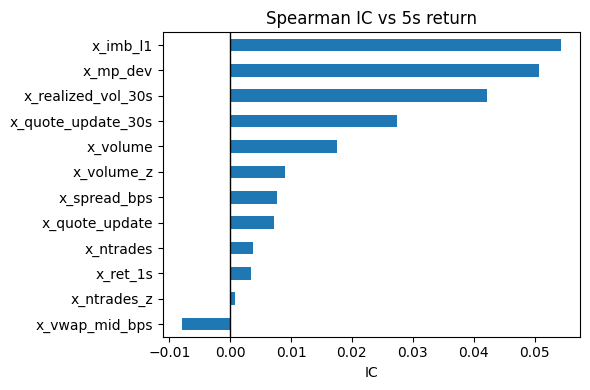

In [57]:
import matplotlib.pyplot as plt

# Spearman Information Coefficient

ic_5s.sort_values().plot(kind="barh", figsize=(6,4))
plt.axvline(0, color="black", linewidth=1)
plt.title("Spearman IC vs 5s return")
plt.xlabel("IC")
plt.tight_layout()
plt.show()


- top-of-the-book imbalance seems to be reflecting the return after 5s strongly.
- microprice deviation also reflects strong positive correlation with 5s return.

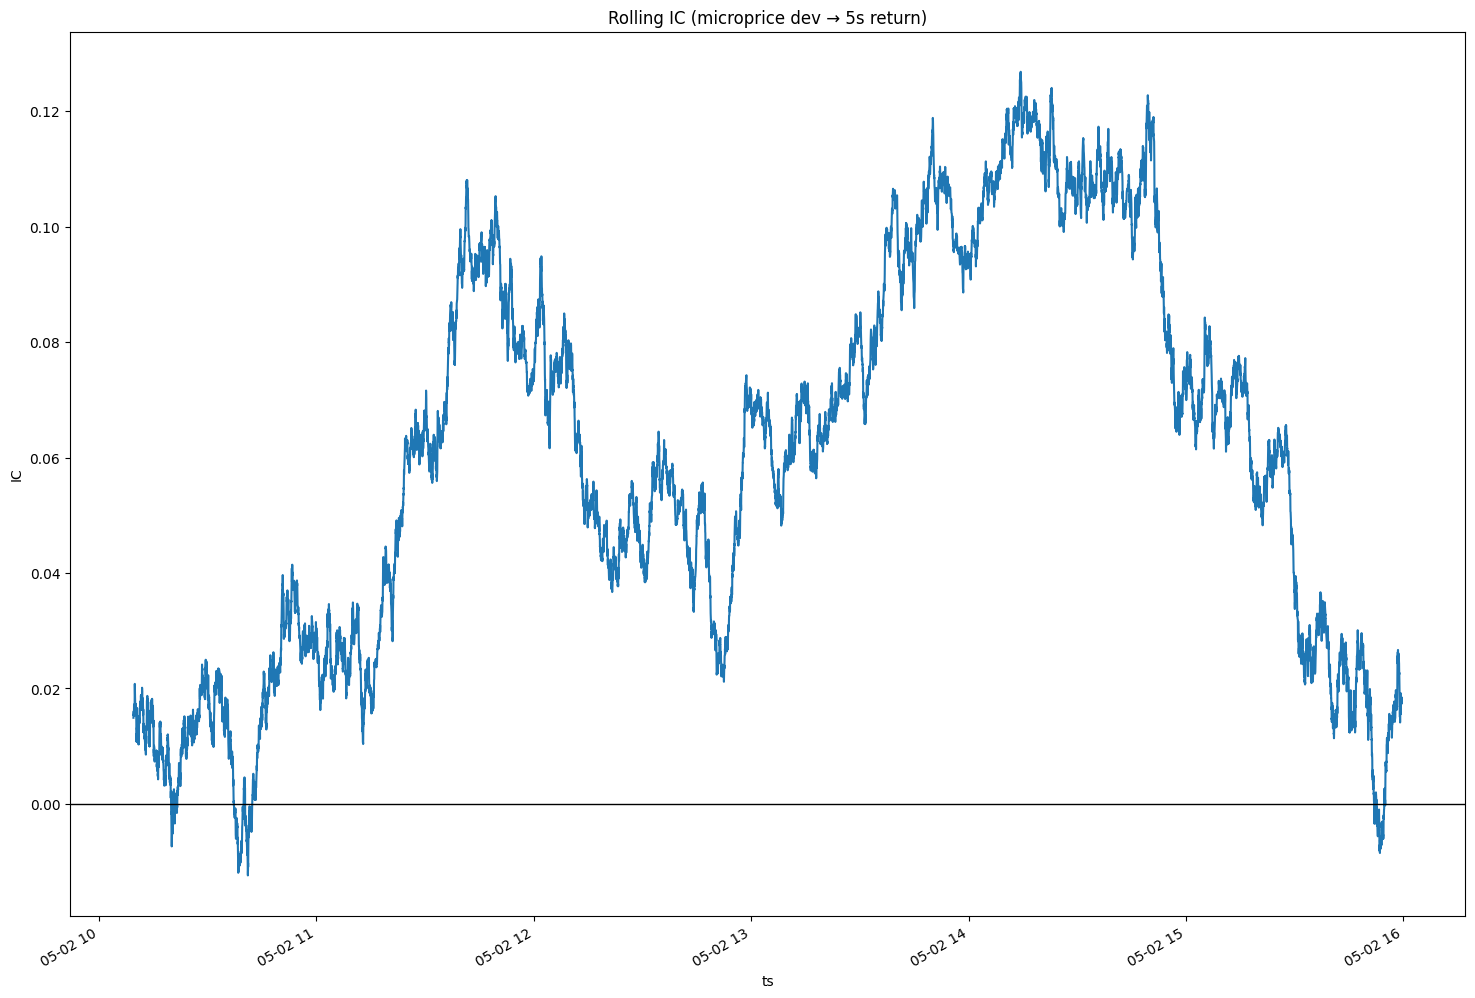

In [59]:
def rolling_ic(x, y, window):
    window = 1800  # e.g. 30 minutes at 1s

    x_rank = x.rank()
    y_rank = y.rank()

    rolling_ic = x_rank.rolling(window).corr(y_rank)
    return rolling_ic

ic_ts = rolling_ic(df["x_mp_dev"], df["y_ret_5s"], window=1800)  # 30 min

ic_ts.plot(figsize=(18,13))
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling IC (microprice dev → 5s return)")
plt.ylabel("IC")
plt.show()


## Horizon Decay

In [60]:
ics = {}

horizons = [1, 5, 10, 20, 30, 60] # seconds

for h in horizons:
    y = np.log(df['q_mid'].shift(-h)) - np.log(df['q_mid'])
    ics[h] = df['x_imb_l1'].corr(y, method='spearman')

ic_decay = pd.Series(ics)


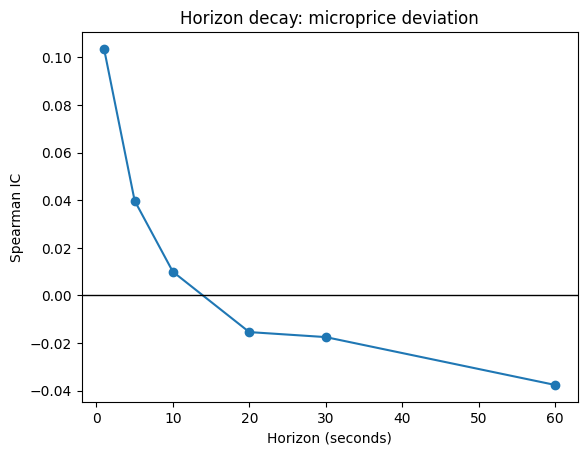

In [61]:
ic_decay.plot(marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Horizon (seconds)")
plt.ylabel("Spearman IC")
plt.title("Horizon decay: microprice deviation")
plt.show()
